# Phân loại chó và mèo

Trong bài này, ta sẽ xây dựng mô hình CNN để phân biệt ảnh của lớp chó và lớp mèo. Đầu tiên ta cần tải dataset từ Kaggle về sử dụng [link](https://www.kaggle.com/c/dogs-vs-cats/data). Chú ý cần phải đăng ký tài khoản trên trang kaggle để có thể tải dữ liệu. Sau khi tải về ta giải nén ra thư mục như sau:

    -dogs-vs-cats
        -train
            -cat.0.jpg
            -dog.0.jpg
        -test1
            -cat.1000.jpg
            -dog.1000.jpg

Khi giải quyết một vấn đề, điều đầu tiên ta nên phân loại vấn đề vô một nhóm, từ đó mới đưa ra cách giải quyết phù hợp. Bài toán này là bài toán phân loại ảnh, nghĩa là input là ảnh (ma trận), và output là class chó hoặc mèo, tức là phân loại nhị phân (binary classification). Có nhiều cách giải quyết vấn đề này, ví dụ như trải phẳng ảnh ra thành vector, rồi sử dụng MLP với lớp sau cùng là 2 neuron, cách này đã được phân tích trong phần bài giảng. 

Trong bài tập này, ta sẽ xây dựng mô hình CNN để giải quyết bài toán.

## Phân tích dữ liệu

Đối với dữ liệu hình ảnh, ta nên tìm cách trả lời những câu hỏi:
- Có bao nhiêu điểm dữ liệu cho mỗi class
- Mỗi điểm dữ liệu trông như thế nào, có gì đặc biệt
- Kích thước ảnh có quá chênh lệch không
- ...

Để trả lời những câu hỏi này, ta phải phân tích dữ liệu trước khi xây dựng mô hình, đây là bước rất quan trọng.

In [6]:
import os
import matplotlib.pyplot as plt

In [4]:
original_dataset_dir = 'D:\\datasets\\dogs-vs-cats\\train'
base_dir = 'D:\\datasets\\dogs-vs-cats\\preprocess'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

## Keras

In [10]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [11]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

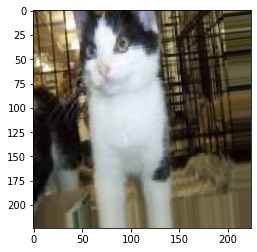

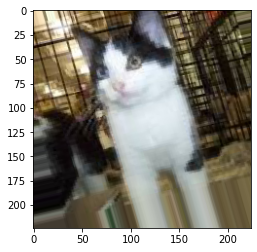

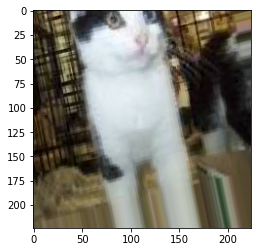

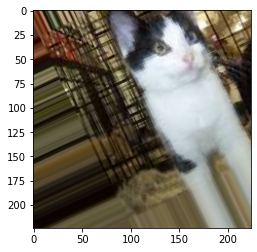

In [12]:
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

img_path = fnames[4] # Choose one image to augment

img = image.load_img(img_path, target_size=(224, 224)) # load image and resize it

x = image.img_to_array(img) # Convert to a Numpy array with shape (224, 224, 3)

x = x.reshape((1,) + x.shape)

# Generates batches of randomly transformed images.
# Loops indefinitely, so you need to break once four images have been created
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [14]:
from keras import layers, models, optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255) # Note that validation data should not be augmented

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=50,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=50,
    class_mode='binary')

Found 16000 images belonging to 2 classes.
Found 4500 images belonging to 2 classes.


In [16]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=960, # 960 x 50 = 48000 (we are showing different augmented images more than once per epoch)
    epochs=30,
    validation_data=validation_generator,
    validation_steps=90) # 90 x 50 == 4500

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
171/960 [====>.........................] - ETA: 13:53 - loss: 0.6783 - acc: 0.5523

KeyboardInterrupt: 

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=50,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=90)
print('test acc:', test_acc)